<p id = 'toc'></p>

<h1 style = "font-family:Verdana; font-size:24px; font-weight: bold; letter-spacing: 3px; color: teal;"> TABLE OF CONTENTS </h1>

---

[<h3 style = "font-family: Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal">0&nbsp;&nbsp;&nbsp;&nbsp; IMPORTS </h3>](#0)

---

<h3 style = "font-family:Verdana; font-size: 18px; text-indent: 8vw; letter-spacing: 2px; color: teal"><a href='#1'>1.&nbsp;&nbsp;&nbsp;&nbsp;DATASET</a></h3>

---




<a id = '0'></a>
# <span><center style = "font-family: Verdana; font-size:36px; color : teal; letter-spacing: 3px; font-weight: bold">0. &nbsp;IMPORTS&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc'>&#10514;</a></center></span>

In [21]:
# pip install pydicom

In [3]:
import pandas as pd 
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import torch
import cv2
import torchvision.transforms as transforms
import shutil


from PIL import Image
from tqdm import tqdm
from torchvision import datasets
from pydicom import dcmread

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

In [4]:
class config:
    TRAIN_PATH = '../input/unifesp-x-ray-body-part-classifier/train'
    TRAIN_CSV = '../input/unifesp-x-ray-body-part-classifier/train.csv'
    WORKING_PATH = './'
    
    RANDOM_SEED = 15

<a id="1"></a>

# <span><center style= "font-family:Verdana; font-size:36px; font-weight: bold; letter-spacing: 3px; color: teal">1.&nbsp;&nbsp;DATASET&nbsp;&nbsp;&nbsp;&nbsp;<a href = '#toc'>&#10514;</a> </center></span>

In [5]:
train_df = pd.read_csv(config.TRAIN_CSV)
train_df.head(10)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20
8,1.2.826.0.1.3680043.8.498.10072001800484199846...,3
9,1.2.826.0.1.3680043.8.498.10077219503857952412...,3


In [6]:
file_names = []
full_paths = []
for dirpath,  dirname, filenames in os.walk(config.TRAIN_PATH):
    if filenames:
        for filename in filenames:
            full_path = os.path.join(dirpath, filename)
            filename = filename[:-6]
            full_paths.append(full_path)
            file_names.append(filename)

In [7]:
image_path_dict = {'SOPInstanceUID': file_names, 'path':full_paths}
image_df = pd.DataFrame(image_path_dict)

In [8]:
train_df = pd.merge(train_df, image_df, on = 'SOPInstanceUID')

In [9]:
train_df.head(8)

,SOPInstanceUID,Target,path
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,../input/unifesp-x-ray-body-part-classifier/tr...
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,../input/unifesp-x-ray-body-part-classifier/tr...
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,../input/unifesp-x-ray-body-part-classifier/tr...
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,../input/unifesp-x-ray-body-part-classifier/tr...
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,../input/unifesp-x-ray-body-part-classifier/tr...
5,1.2.826.0.1.3680043.8.498.10053755320637729867...,3,../input/unifesp-x-ray-body-part-classifier/tr...
6,1.2.826.0.1.3680043.8.498.10062189329714053601...,14,../input/unifesp-x-ray-body-part-classifier/tr...
7,1.2.826.0.1.3680043.8.498.10065930002825553435...,13 20,../input/unifesp-x-ray-body-part-classifier/tr...


In [10]:
train_df.shape

(1738, 3)

# <span><center style = "font-family:Verdana; font-size:36px; letter-spacing:2px; font-weight:bold; color:teal">2.&nbsp;&nbsp;VISUALIZATION&nbsp;&nbsp;&nbsp;&nbsp;<a href='#toc'>&#10514;</a></center></span>

<a id="2"></a>


In [11]:
def read_dicom_image(path):
    dicom_file = dcmread(path)
    image = dicom_file.pixel_array
    image = image/image.max()
    return image

In [12]:
def save_image_jpg(path, save_path_name):
    image = read_dicom_image(path)*255
    plt.imsave(save_path_name, image)

In [16]:
os.listdir()

['__notebook_source__.ipynb', 'train', '.virtual_documents']

In [14]:
shutil.rmtree('./train')

FileNotFoundError: [Errno 2] No such file or directory: './train'

In [15]:
os.mkdir('./train')

In [19]:
train_df[100:].shape

(100, 3)

In [23]:
for i in tqdm(range(200, 500)):
    save_image_jpg(train_df.path[i], f'./train/{train_df.SOPInstanceUID[i]}.jpg')

100%|██████████| 300/300 [18:35<00:00,  3.72s/it]


In [ ]:
save_image_jpg(train_df.path[0], f'./train/{train_df.SOPInstanceUID[0]}.jpeg')

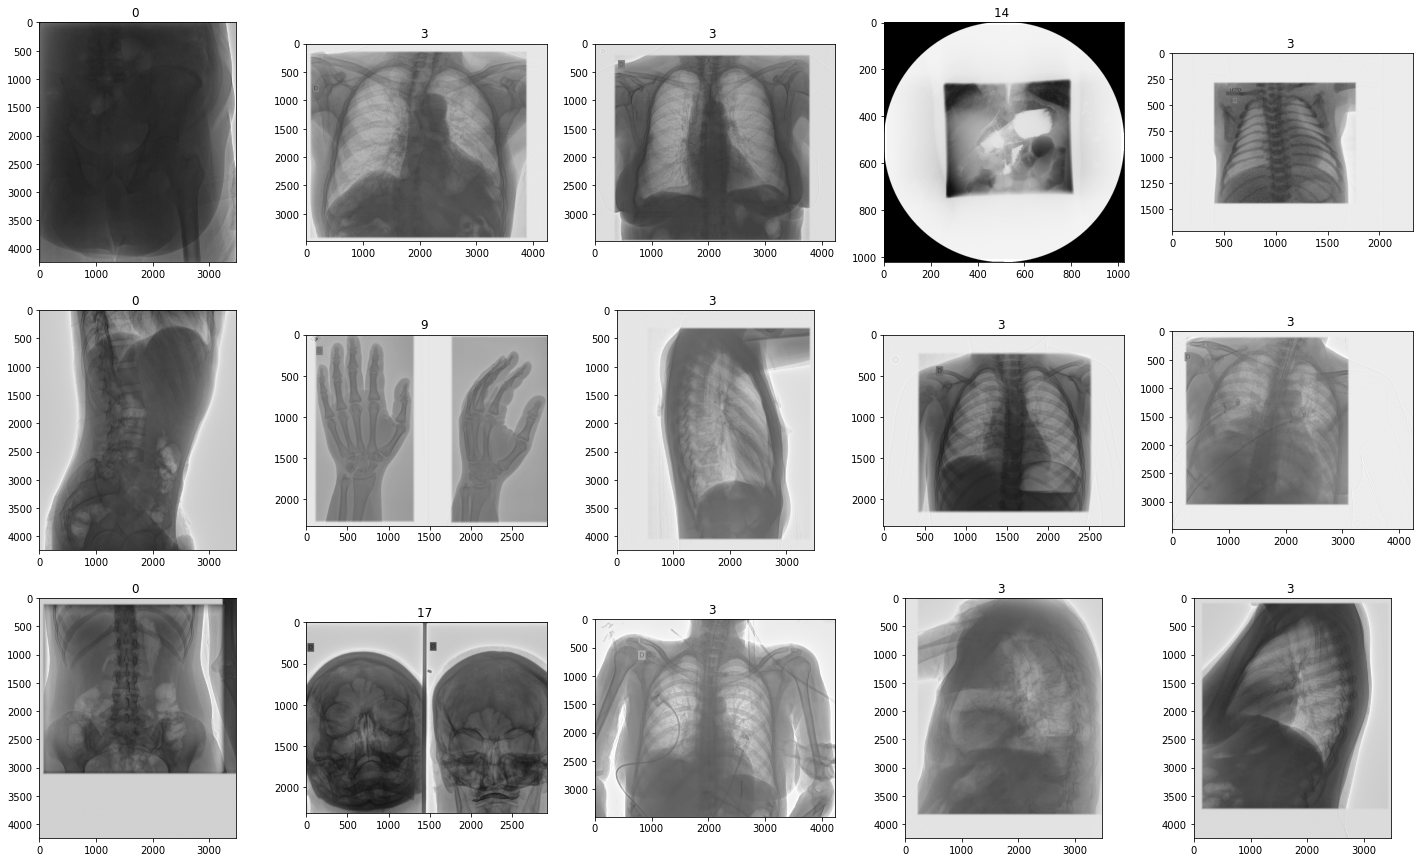

In [22]:
fig = plt.figure(figsize=(25,15))
for i in range(15):
    ax = fig.add_subplot(3,5, i+1)
    image = read_dicom_image(train_df.path[i*5])
    plt.imshow(image, cmap = 'gray')
    ax.set_title(train_df.Target[i*5])


In [ ]:
X = read_dicom_image(train_df.path[20])
plt.imshow(X)
train_df.Target[20]

In [ ]:
plt.imsave('trial.jpeg', X)